In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

Importar bibliotecas

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.utils.data import Dataset
import csv
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter




['anger' 'disgust' 'fear' 'joy' 'others' 'sadness' 'surprise']
6727
1682
5045
1682
['anger', 'joy', 'others', 'surprise', 'joy', 'others', 'disgust', 'others', 'others', 'joy', 'joy', 'others', 'others', 'others', 'others', 'others', 'joy', 'others', 'others', 'others', 'others', 'anger', 'joy', 'joy', 'anger', 'surprise', 'disgust', 'joy', 'fear', 'others', 'others', 'sadness', 'others', 'sadness', 'sadness', 'others', 'fear', 'others', 'anger', 'sadness', 'disgust', 'fear', 'others', 'joy', 'others', 'sadness', 'anger', 'anger', 'sadness', 'anger', 'joy', 'anger', 'others', 'others', 'fear', 'others', 'others', 'others', 'others', 'others', 'sadness', 'fear', 'joy', 'others', 'others', 'anger', 'joy', 'others', 'others', 'others', 'others', 'others', 'others', 'anger', 'fear', 'others', 'others', 'joy', 'others', 'joy', 'others', 'sadness', 'others', 'others', 'others', 'joy', 'others', 'joy', 'joy', 'joy', 'others', 'others', 'others', 'sadness', 'others', 'others', 'joy', 'others',

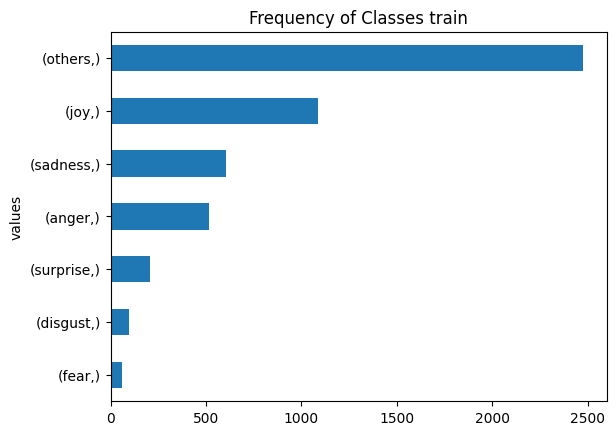

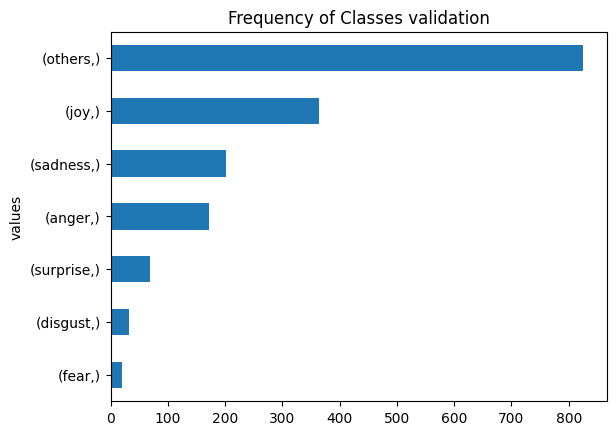

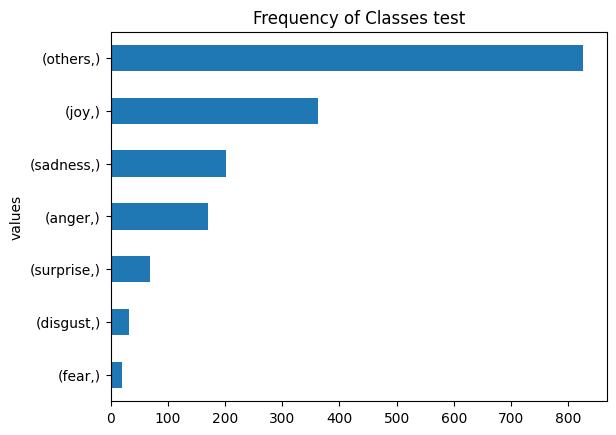

In [ ]:
# Corpus
text_filepath = "/content/emoevent_es.csv"

#text_data = pd.read_csv(text_filepath)
text_data = pd.read_csv(text_filepath, sep='\t', engine = 'python', usecols=[1])
labels_data = pd.read_csv(text_filepath, sep='\t', engine = 'python', usecols=[2])
X = text_data.iloc[:, 0].tolist()
y = labels_data.iloc[:, 0].tolist()
label_name = np.unique(y)
print (label_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify= y)
print (len(X_train))
print (len(X_test))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0, stratify= y_train) # 0.25 x 0.8 = 0.2
print (len(X_train))
print (len(X_val))


#print (labels_data)
#label_name = np.unique(labels_data)
#print (label_name)
#train_labels, test_labels = train_test_split(labels_data.iloc[:, 0].tolist(), test_size=0.2, random_state=0)
le = LabelEncoder()
y_train_labels = le.fit_transform(y_train)
y_test_labels = le.transform(y_test)
y_val_labels = le.transform(y_val)
print(y_train)
print (y_train_labels)
print(y_val)
print (y_val_labels)
print(y_test)
print (y_test_labels)
columns = ['values']
pd.DataFrame(y_train, columns = columns).value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes train')
plt.show()
pd.DataFrame(y_val, columns = columns).value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes validation')
plt.show()
pd.DataFrame(y_test, columns = columns).value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes test')
plt.show()

In [ ]:
#@title Carga del modelo
# Tokenización y codificación del corpus de entrenamiento y pruebas
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

train_encodings = tokenizer(X_train, truncation=True, padding=True)
validation_encodings = tokenizer(X_val, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, y_train_labels)
validation_dataset = CustomDataset(validation_encodings, y_val_labels)
test_dataset = CustomDataset(test_encodings, y_test_labels)

# Carga del modelo preentrenado y ajuste fino
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', num_labels = 7)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
 labels = pred.label_ids
 preds = pred.predictions.argmax(-1)
 f1 = f1_score(labels, preds, average="macro")
 acc = accuracy_score(labels, preds)
 return {"accuracy": acc, "f1": f1}

# Nueva sección

In [ ]:
training_args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=100,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
     compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1
100,No log,1.196186,0.570155,0.221170
200,No log,1.001405,0.656361,0.358003
300,No log,1.109605,0.649822,0.361471
400,No log,0.968804,0.677765,0.414454
500,1.076800,0.975684,0.660523,0.355729
600,1.076800,0.876524,0.696195,0.388426
700,1.076800,0.999018,0.687872,0.468518
800,1.076800,0.916109,0.692628,0.505652
900,1.076800,1.037653,0.691439,0.481799
1000,0.724300,0.992160,0.699762,0.476814


TrainOutput(global_step=1893, training_loss=0.6727551008366556, metrics={'train_runtime': 295.56, 'train_samples_per_second': 51.208, 'train_steps_per_second': 6.405, 'total_flos': 987813092918250.0, 'train_loss': 0.6727551008366556, 'epoch': 3.0})

Predicción

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predecir en el conjunto de prueba
predictions = trainer.predict(test_dataset)

# Las predicciones están en formato logit, así que las convertimos a clases usando argmax
predicted_classes = np.argmax(predictions.predictions, axis=-1)

# Classification report
report = classification_report(y_test_labels, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.41      0.49       171
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        19
           3       0.71      0.44      0.54       363
           4       0.64      0.92      0.75       826
           5       0.80      0.56      0.66       202
           6       0.00      0.00      0.00        69

    accuracy                           0.66      1682
   macro avg       0.39      0.33      0.35      1682
weighted avg       0.62      0.66      0.62      1682



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
 cm = confusion_matrix(y_true, y_preds, normalize="true")
 fig, ax = plt.subplots(figsize=(6, 6))
 disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
 disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
 plt.title("Normalized confusion matrix")
 plt.show()

[5, 4, 3, 3, 0, 3, 4, 2, 4, 4, 4, 3, 3, 5, 4, 3, 4, 0, 4, 4, 4, 4, 4, 0, 4, 4, 6, 3, 4, 4, 4, 5, 3, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 6, 4, 0, 4, 5, 4, 3, 4, 4, 4, 5, 3, 3, 4, 4, 4, 5, 3, 0, 3, 5, 5, 4, 5, 3, 4, 4, 4, 0, 4, 6, 3, 4, 4, 3, 3, 6, 5, 4, 4, 3, 4, 4, 3, 3, 4, 6, 6, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, 3, 3, 4, 6, 5, 4, 4, 4, 4, 1, 3, 4, 3, 4, 4, 4, 3, 4, 3, 0, 1, 4, 4, 6, 4, 4, 4, 4, 4, 4, 0, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 6, 4, 4, 3, 4, 4, 3, 4, 4, 4, 3, 4, 5, 4, 4, 3, 4, 2, 4, 4, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4, 3, 4, 4, 3, 3, 4, 4, 4, 5, 4, 4, 4, 3, 5, 4, 0, 0, 3, 3, 3, 4, 4, 5, 0, 3, 4, 3, 4, 4, 5, 3, 0, 4, 3, 5, 5, 3, 4, 0, 0, 3, 4, 4, 4, 5, 0, 4, 4, 4, 4, 5, 4, 6, 3, 4, 4, 4, 1, 4, 3, 4, 3, 3, 4, 0, 4, 1, 4, 4, 3, 0, 4, 1, 0, 3, 4, 3, 4, 4, 0, 3, 4, 5, 3, 2, 3, 4, 4, 4, 3, 3, 0, 6, 4, 4, 3, 6, 4, 0, 3, 4, 4, 3, 6, 4, 4, 4, 4, 4, 5, 5, 5, 6, 4, 5, 3, 4, 4, 3, 4, 0, 6, 4, 4, 4, 3, 4, 4, 0, 4, 4, 0, 5, 4, 3, 0, 4, 0, 3, 4, 4, 0, 4, 

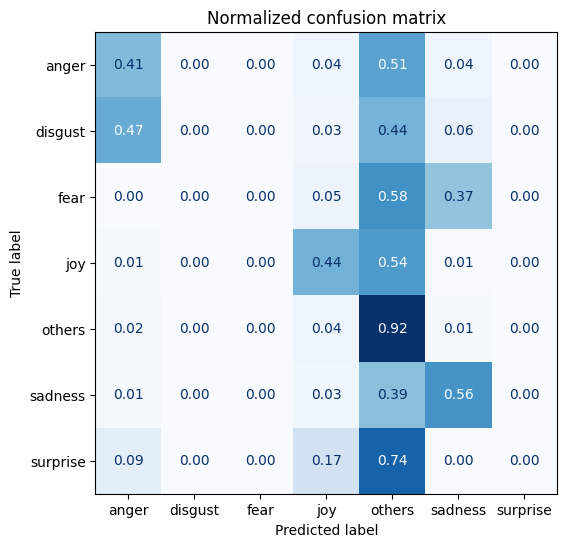

In [ ]:
import numpy as np
y_test = y_test_labels.tolist()
print (y_test)
plot_confusion_matrix(predicted_classes, y_test, label_name)
